In [89]:
import pandas as pd
import numpy as np
import re
import random
import time
import torch
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

data = pd.read_csv('Reviews.csv')

In [90]:
data.columns

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

In [91]:
## Dropping the column
updated_data = data.drop('Unnamed: 0',axis=1)

In [92]:
updated_data = updated_data[updated_data['Clothing ID'] == 1078]

In [93]:
updated_data.isnull().sum()

Clothing ID                  0
Age                          0
Title                      153
Review Text                 37
Rating                       0
Recommended IND              0
Positive Feedback Count      0
Division Name                0
Department Name              0
Class Name                   0
dtype: int64

In [94]:
updated_data = updated_data.dropna()

In [95]:
updated_data

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
69,1078,56,Great summer fabric!,"I really wanted this to work. alas, it had a s...",3,0,1,General Petite,Dresses,Dresses
90,1078,51,Sweet flattering dress,"I love cute summer dresses and this one, espec...",4,1,0,General Petite,Dresses,Dresses
467,1078,61,Great sweater dress!,"Nice fit and flare style, not clingy at all. i...",5,1,1,General,Dresses,Dresses
470,1078,33,"Cute, but cheap",When i first opened this dress and tried it on...,3,0,0,General,Dresses,Dresses
474,1078,20,Super cute and flattering too,I love this sweater dress and get compliments ...,5,1,1,General,Dresses,Dresses
...,...,...,...,...,...,...,...,...,...,...
22992,1078,35,"Take car with it, but it's gorgeous",I love this dress. i agree with the other revi...,4,1,8,General Petite,Dresses,Dresses
22998,1078,36,Flattering and unique,"Beautiful, unique design. it's very flattering...",4,1,2,General Petite,Dresses,Dresses
23004,1078,54,Breathtaking!,This is the most beautiful dress i've ever own...,5,1,0,General,Dresses,Dresses
23460,1078,34,Such high hopes!,I purchased this for a very good price and i t...,3,0,0,General,Dresses,Dresses


In [96]:
updated_data["Department Name"].unique()

array(['Dresses'], dtype=object)

In [97]:
dummy_data = updated_data[['Review Text','Recommended IND']]

In [98]:
dummy_data['Review Text'].iloc[3]

"When i first opened this dress and tried it on i thought it was adorable. it is very flattering on my hourglass figure and hides my recent baby weight. the problem is the hem. it was already rolling up when i took it out of the package, and i should have noticed and returned it, but i figured the problem would be easily solved by a good ironing. well, it wasn't, and it gets worse every time i wash the dress. it's like the hem isn't constructed properly."

In [99]:
dummy_data.rename(columns = {'Recommended IND':'Recommended','Review Text':'Text'}, inplace= True)

/tmp/ipykernel_102789/742937973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummy_data.rename(columns = {'Recommended IND':'Recommended','Review Text':'Text'}, inplace= True)


In [100]:
X  = dummy_data['Text']
y = dummy_data['Recommended']

In [101]:
X_train, X_val, y_train, y_val= train_test_split(X,y, test_size = 0.2 , random_state = True)

In [102]:
X_train

7871     I bought this dress on super sale and it was s...
7881     This dress drapes very well and is flattering ...
13234    This dress is soft and comfortable. it's perfe...
2521     This dress is gorgeous yet sturdy, it is all a...
8649     Pretty, easy-to-wear dress. loose fitting. i a...
                               ...                        
19300    I bought this dress in the red option. was a l...
20341    This dress is the perfect length and so comfor...
3708     As soon as i opened the package, i knew that t...
7068     This dress is everything everyone said it was ...
1925     I never write reviews but this dress is so fan...
Name: Text, Length: 696, dtype: object

In [103]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [104]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [105]:
# Print sentence 0
X = X.to_list()
#print("Original :",X.to_list())
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:  I really wanted this to work. alas, it had a strange fit for me. the straps would not stay up, and it had a weird fit under the breast. it worked standing up, but the minute i sat down it fell off my shoulders. the fabric was beautiful! and i loved that it had pockets.
Processed:  I really wanted this to work. alas, it had a strange fit for me. the straps would not stay up, and it had a weird fit under the breast. it worked standing up, but the minute i sat down it fell off my shoulders. the fabric was beautiful! and i loved that it had pockets.


In [106]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [107]:
# Concatenate train data and test data
all_tweets = np.concatenate([X])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  154


In [108]:
# Specify `MAX_LEN`
MAX_LEN = 64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  I really wanted this to work. alas, it had a strange fit for me. the straps would not stay up, and it had a weird fit under the breast. it worked standing up, but the minute i sat down it fell off my shoulders. the fabric was beautiful! and i loved that it had pockets.
Token IDs:  [101, 1045, 2428, 2359, 2023, 2000, 2147, 1012, 21862, 2015, 1010, 2009, 2018, 1037, 4326, 4906, 2005, 2033, 1012, 1996, 19702, 2052, 2025, 2994, 2039, 1010, 1998, 2009, 2018, 1037, 6881, 4906, 2104, 1996, 7388, 1012, 2009, 2499, 3061, 2039, 1010, 2021, 1996, 3371, 1045, 2938, 2091, 2009, 3062, 2125, 2026, 4065, 1012, 1996, 8313, 2001, 3376, 999, 1998, 1045, 3866, 2008, 2009, 102]
Tokenizing data...


/home/himanshu/anaconda3/envs/deeplearning/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [109]:
# Convert other data types to torch.Tensor
y_train = list(y_train)
y_val = list(y_val)
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [110]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 27 µs, sys: 1 µs, total: 28 µs
Wall time: 31.7 µs


In [111]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
`    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [112]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            #b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            b_input_ids, b_attn_mask, b_labels = tuple(t for t in batch)
            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        #b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        b_input_ids, b_attn_mask, b_labels = tuple(t for t in batch)
        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy


In [113]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/himanshu/anaconda3/envs/deeplearning/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is dep

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.487194   |     -      |     -     |   45.70  
   1    |   21    |   0.468000   |     -      |     -     |   1.85   
----------------------------------------------------------------------
   1    |    -    |   0.486322   |  0.411127  |   83.26   |   50.82  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.367372   |     -      |     -     |   46.05  
   2    |   21    |   0.564071   |     -      |     -     |   1.64   
----------------------------------------------------------------------
   2    |    -    |   0.376313   |  0.336822  |   83.26   |   50.89  
----------------------------------------------------------------

In [114]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []
    
    # For each batch in our test set...
    for batch in test_dataloader:
        print("test_dataloader",test_dataloader)
        # Load batch to GPU
        #b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]
        b_input_ids, b_attn_mask = tuple(t for t in batch)[:2]
        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [115]:

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [116]:
print(val_dataloader)

test_dataloader <torch.utils.data.dataloader.DataLoader object at 0x7f655e896700>
test_dataloader <torch.utils.data.dataloader.DataLoader object at 0x7f655e896700>
test_dataloader <torch.utils.data.dataloader.DataLoader object at 0x7f655e896700>
test_dataloader <torch.utils.data.dataloader.DataLoader object at 0x7f655e896700>
test_dataloader <torch.utils.data.dataloader.DataLoader object at 0x7f655e896700>
test_dataloader <torch.utils.data.dataloader.DataLoader object at 0x7f655e896700>
AUC: 0.8835
Accuracy: 82.29%


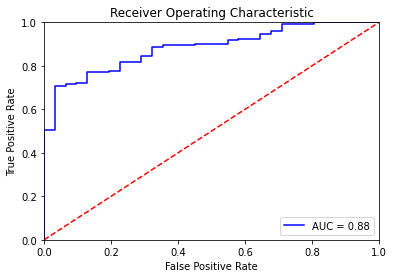

In [117]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

#probs = np.round(probs)
#probs = probs.astype('int')
#print(probs)
# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [118]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/himanshu/anaconda3/envs/deeplearning/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is dep

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.480992   |     -      |     -     |   46.05  
   1    |   27    |   0.378464   |     -      |     -     |   14.32  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.319161   |     -      |     -     |   45.41  
   2    |   27    |   0.330985   |     -      |     -     |   13.85  
----------------------------------------------------------------------


Training complete!


In [119]:
def preprocessing_for_bert_1(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(data),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
    input_ids.append(encoded_sent.get('input_ids'))
    attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [120]:
def prediction(testloader):
    test_inputs, test_masks = preprocessing_for_bert_1(testloader)

    with torch.no_grad():
        preds = bert_classifier(test_inputs,test_masks)
        preds = preds.detach().cpu().numpy()

    preds = np.argmax(preds,axis=1)
    return preds

In [121]:
testloader = "I really wanted this to work. alas, it had a strange fit for me. the straps would not stay up, and it had a weird fit under the breast. it worked standing up, but the minute i sat down it fell off my shoulders. the fabric was beautiful! and i loved that it had pockets."
result=prediction(testloader)
if result[0] == 1:
    print('Good')
else:
    print('Not Good')

Good


/home/himanshu/anaconda3/envs/deeplearning/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
